## Load reference datasets

In [1]:
#!pip install xlrd
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris

X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame = True, return_X_y = True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "airfoil": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        header=None,
        sep="\\t",
    ),
    "blood": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
    ),
    "bc": X_raw_breast_cancer,
    "california": X_raw_california,
    "climate": climate_model_df,
    "compression": pd.read_excel(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    ),
    "slump": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data"
    ),
    "sonar": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
        header=None,
    ),
    "diabetes": X_raw_diab,
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "yeast": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data",
        sep="\s+",
        header=None,
    ),
    "iris": X_raw_iris,
    "libras":pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",sep=",", header = None),
    "parkinsons": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",sep=","),
    "yacht": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",sep="\s+", header = None),
    "ionosphere": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",sep=",", header = None),
    "letter": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data", header = None),
    "spam":pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"),
    "credit":pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data", header = None),
}

/code/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
from pathlib import Path
import json
import pandas as pd

output_dir = Path("diagrams")
output_dir.mkdir(parents=True, exist_ok=True)

rmse_key = "Mean RMSE"
wass_key = "Mean Wasserstein distance"
pred_key = "Mean downstream prediction error"

data = {}

results = Path("paper_results").glob('*')

df_names = ['airfoil',
 'bc',
 #'blood',
 #'california',
 #'climate',
 'compression',
 'diabetes',
 'ionosphere',
 'iris',
 'libras',
 'letter',
 'credit',
 'spam',
 'parkinsons',
 #'slump',
 #'sonar',
 'wine_red',
 'wine_white',
 #'yacht',
 'yeast'
           ]

for res in results:
    if "debug" in res.name:
        continue

    if res.name not in df_names:
        continue
        
    with open(res) as f:
        local_data = json.load(f)
        
        headers = local_data["headers"]
        rmse = pd.DataFrame(local_data["rmse"], columns = headers)
        wasserstein = pd.DataFrame(local_data["wasserstein"], columns = headers)
        downstream = pd.DataFrame(local_data["downstream"], columns = headers)
        
    data[res.name] = {
        rmse_key: rmse,
        wass_key: wasserstein,
        #pred_key: downstream,
    }

In [3]:
df_names = sorted(data.keys())

## Parse results

In [4]:
import pandas as pd
import numpy as np

from io import StringIO



models_cnt = len(headers) - 2
results = {}

df_names = sorted(data.keys())

remap_models = {
    "Our method": "hyperimpute",
    "sklearn_missforest": "missforest",
    "sklearn_ice": "ice",
}
norm_cols = [
    "Our method",
    "mean",
    "sklearn_missforest",
    "sklearn_ice",
    "gain",
    "sinkhorn",
    "softimpute",
]


for dataset in df_names:    
    for metric in data[dataset]:
        df = data[dataset][metric]

        # Prediction norm
        num_df = df._get_numeric_data()
        num_df[num_df <= 0] = 1e-6

        for scenario in ["MNAR", "MCAR", "MAR"]:
            if scenario not in results:
                results[scenario] = {}

            for miss in [0.1, 0.3, 0.5, 0.7]:
                if miss not in results[scenario]:
                    results[scenario][miss] = {}

                local_df = df[df["Scenario"] == scenario].drop(columns=["Scenario"])
                local_df = local_df[local_df["miss_pct [0, 1]"] == miss].drop(
                    columns=["miss_pct [0, 1]"]
                )

                local_df = local_df.rename(columns=remap_models)

                if len(local_df) == 0:
                    continue

                if metric not in results[scenario][miss]:
                    results[scenario][miss][metric] = {}
                for col in local_df.columns:
                    if col not in results[scenario][miss][metric]:
                        results[scenario][miss][metric][col] = []
                    results[scenario][miss][metric][col].append(min(local_df[col].values[0], 1))

## General overview

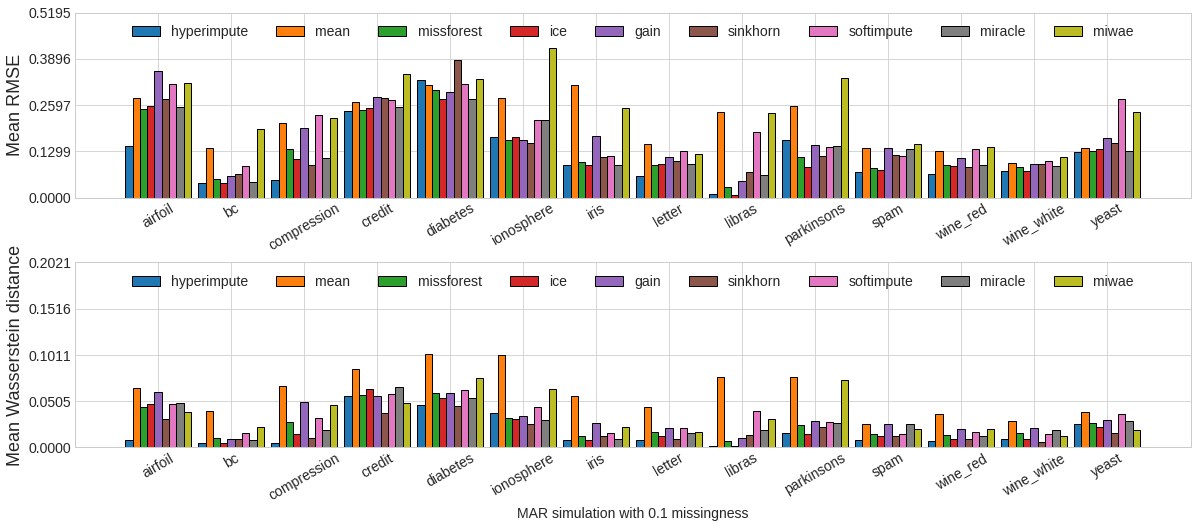

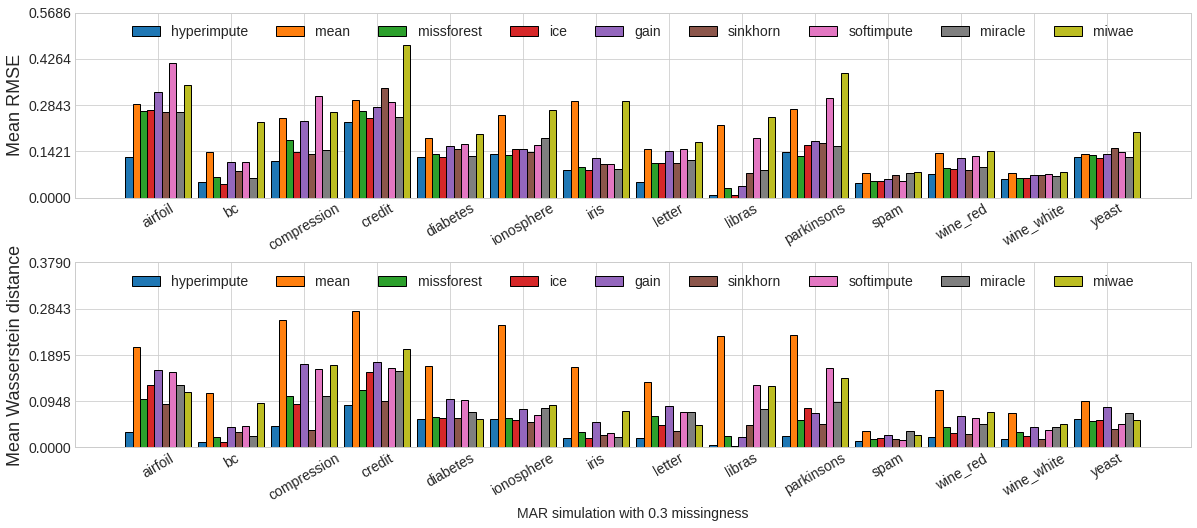

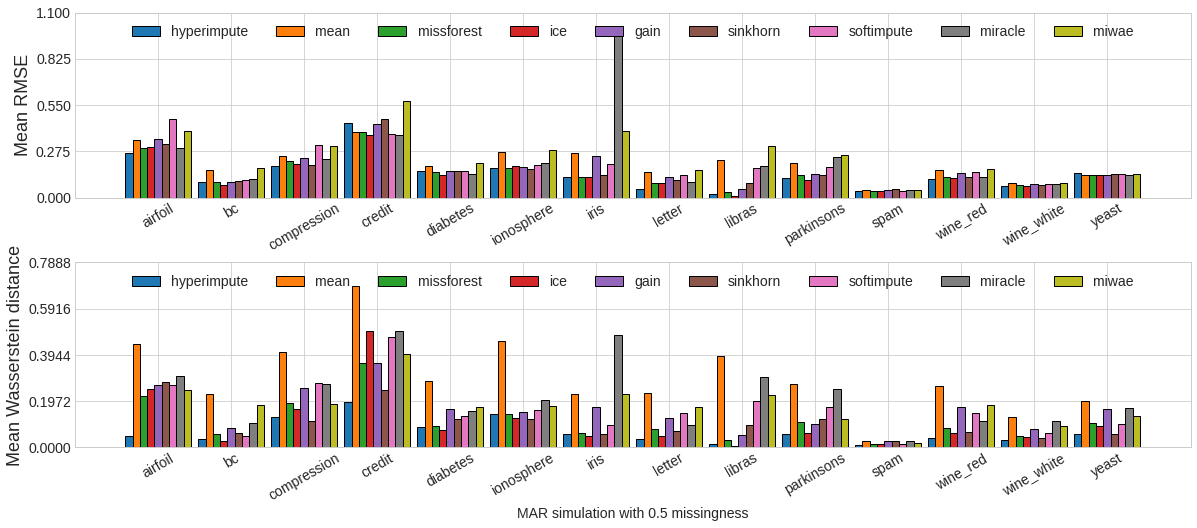

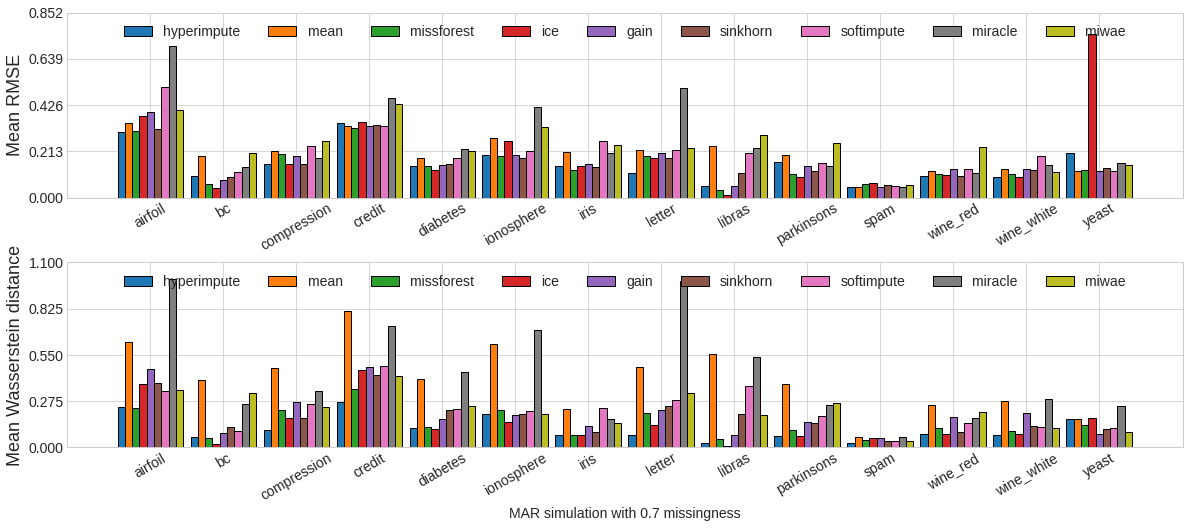

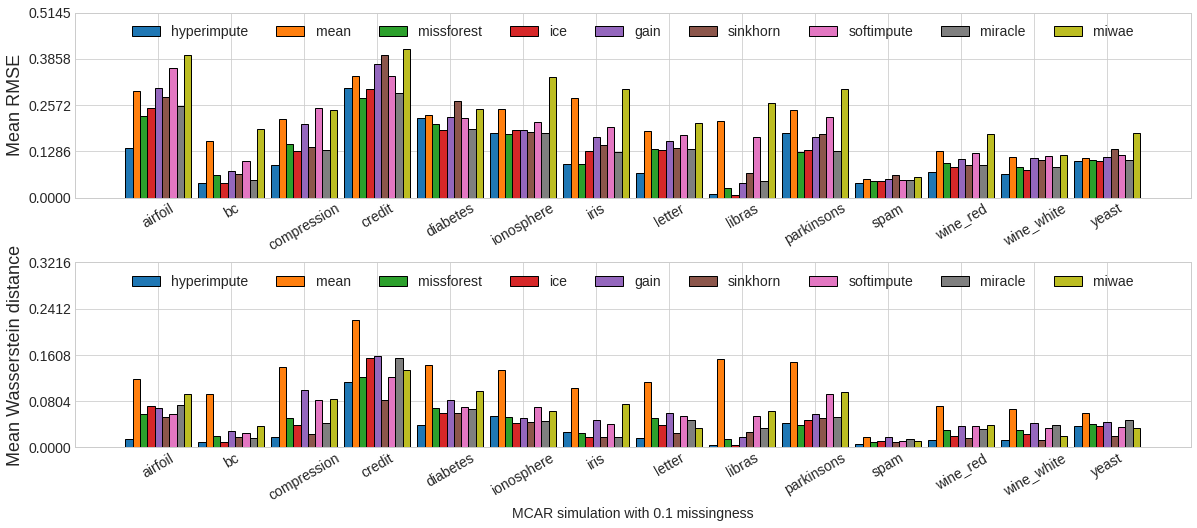

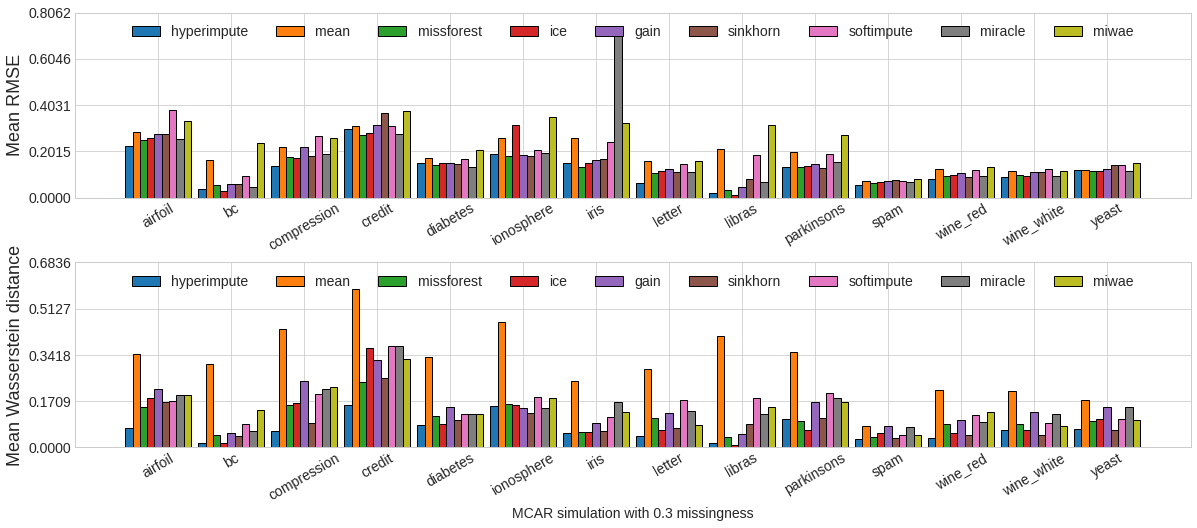

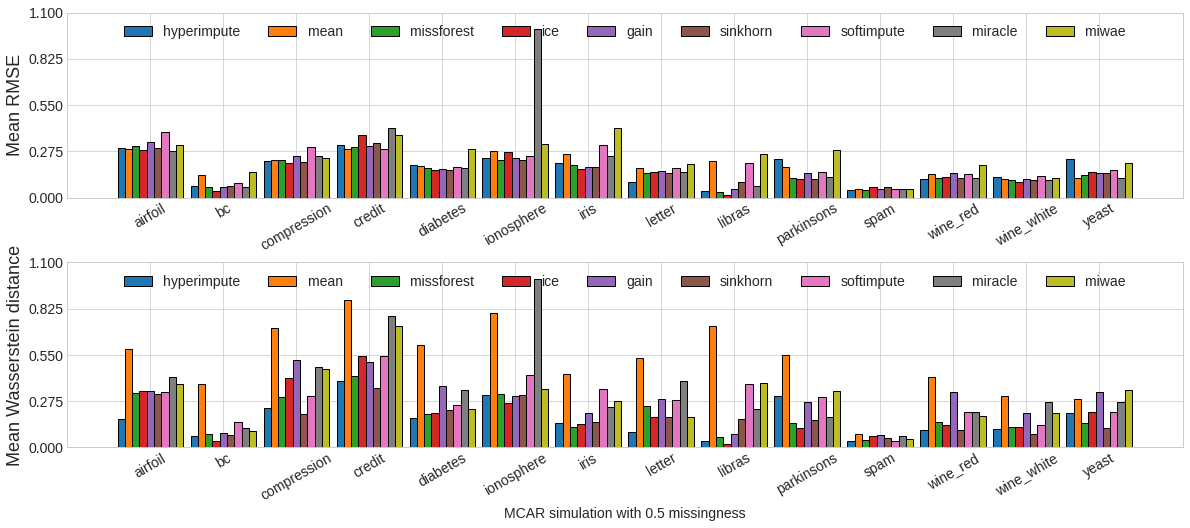

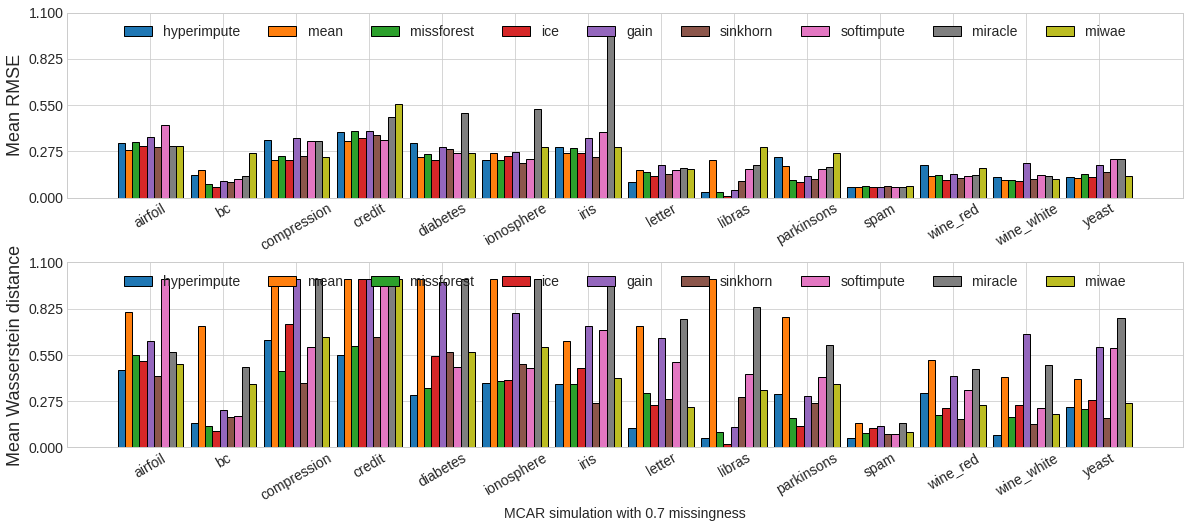

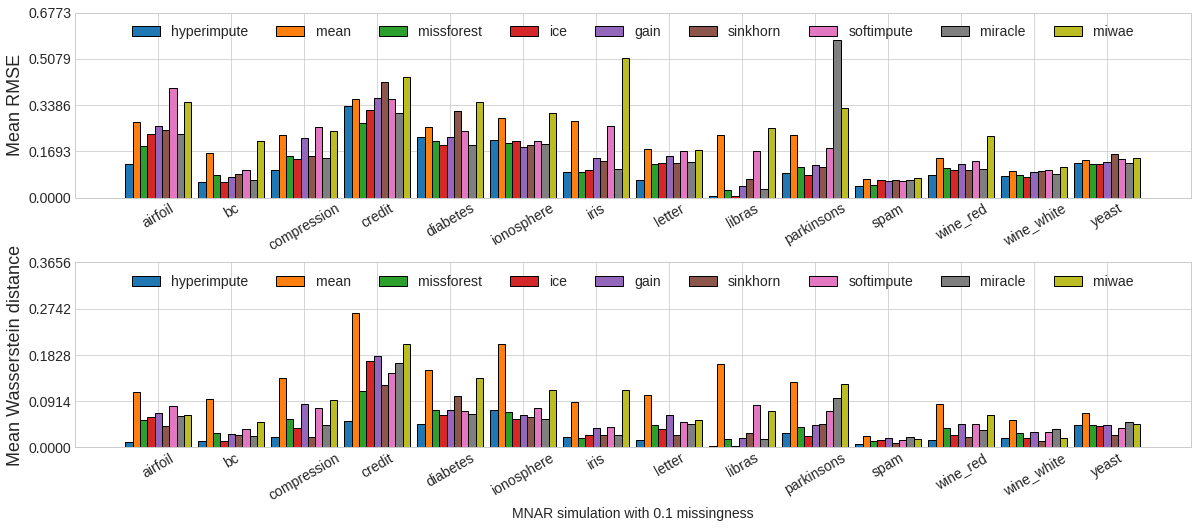

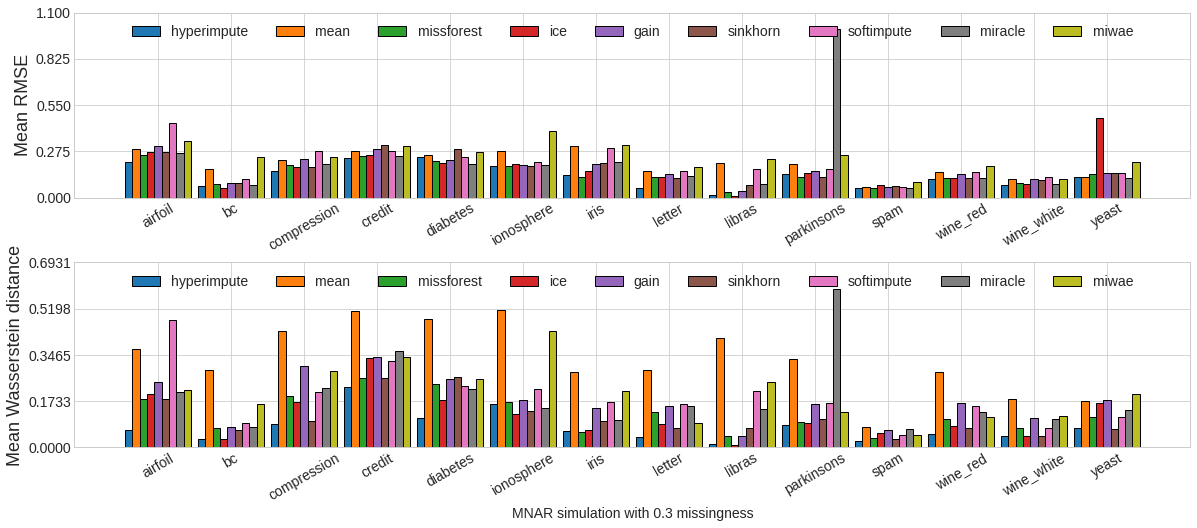

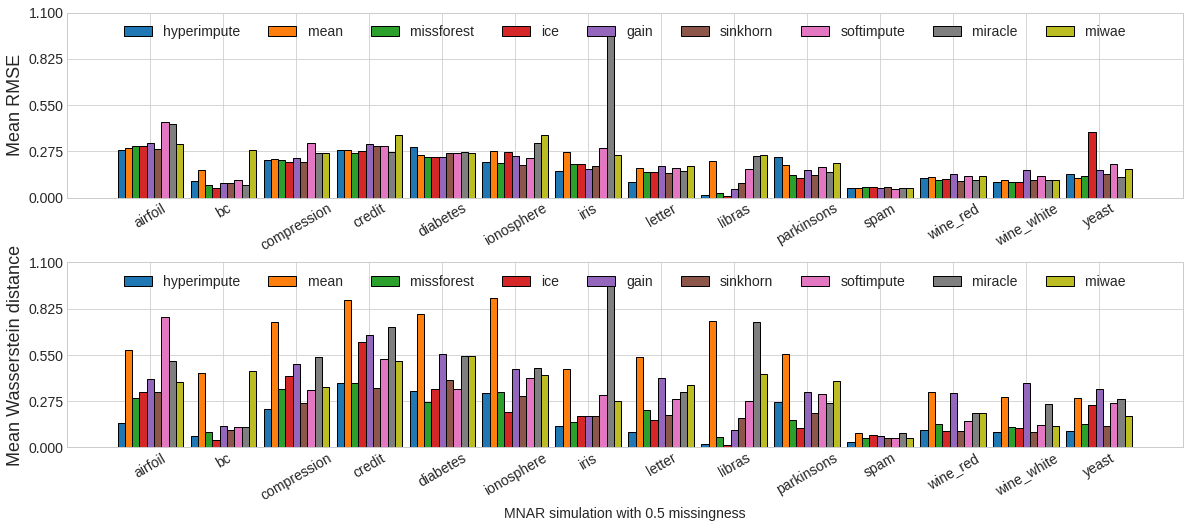

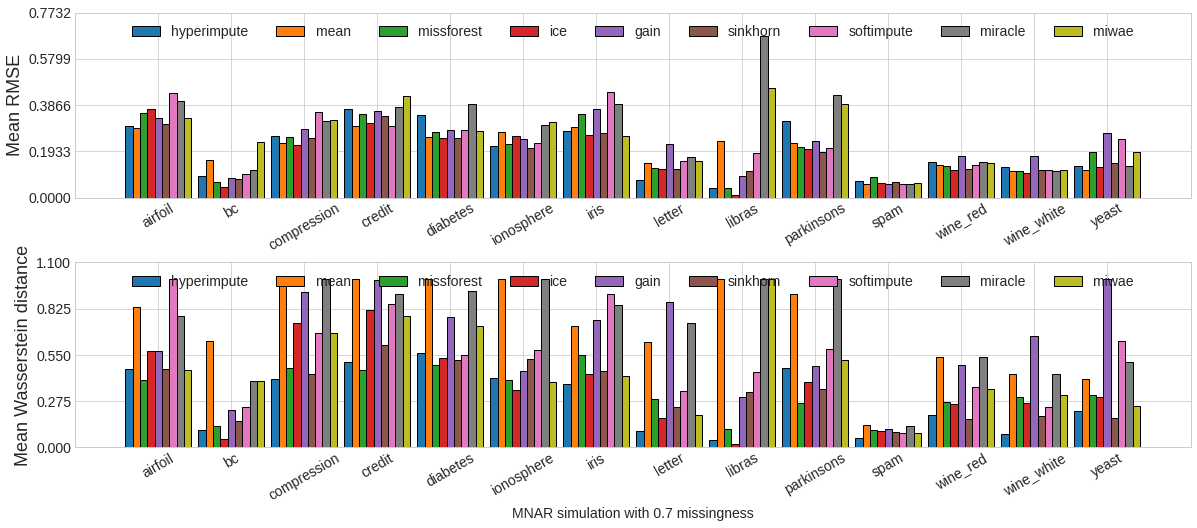

In [5]:
import matplotlib.pyplot as plt

fontsize = 14
df_graph_len = models_cnt + 1

def generate_plot_for_ax(ax, scenario, miss, metric):
    offset = len(data)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    barWidth = 1

    max_val = 0
    idx = 0
    for model in results[scenario][miss][metric]:
        pos = [idx + df_graph_len * i * barWidth for i in range(offset)]

        if max_val < max(results[scenario][miss][metric][model]):
            max_val = max(results[scenario][miss][metric][model])
        ax.bar(
            pos,
            results[scenario][miss][metric][model],
            width=barWidth,
            label=str(model),
            edgecolor="k",
        )
        idx += barWidth

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=models_cnt,
        prop={"size": fontsize},
    )

    ax.set_xticks(
        [df_graph_len * r + int(models_cnt / 2) for r in range(offset)],
        df_names,
        rotation=30,
        fontsize=fontsize,
    )
    ax.set_yticks(np.linspace(0, max_val + 0.1, num=5), fontsize=fontsize)
    ax.set_ylabel(metric, fontsize=fontsize + 4)

    return ax


def generate_plot(scenario, miss):
    plt.style.use("seaborn-whitegrid")

    offset = len(data)
    metrics = list(results[scenario][miss].keys())
    fig, axs = plt.subplots(len(metrics), figsize=(20, 8))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax(axs[idx], scenario, miss, metric)

    # plt.title(f"{scenario} simulation with {miss} missingness", fontdict = {"fontsize": 150}, loc = "top")
    plt.xlabel(f"{scenario} simulation with {miss} missingness", fontsize=fontsize)
    plt.subplots_adjust(hspace = 0.35)

    plt.savefig(output_dir / f"general_overview_{scenario}_{miss}.png")
    plt.show()


for scenario in ["MAR", "MCAR", "MNAR"]:
    for miss in [0.1, 0.3, 0.5, 0.7]:
        generate_plot(scenario, miss)

In [6]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

## By missingness

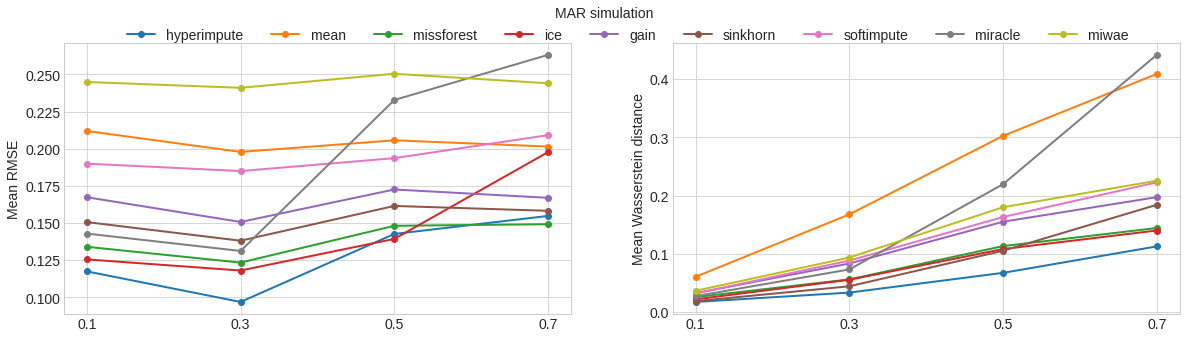

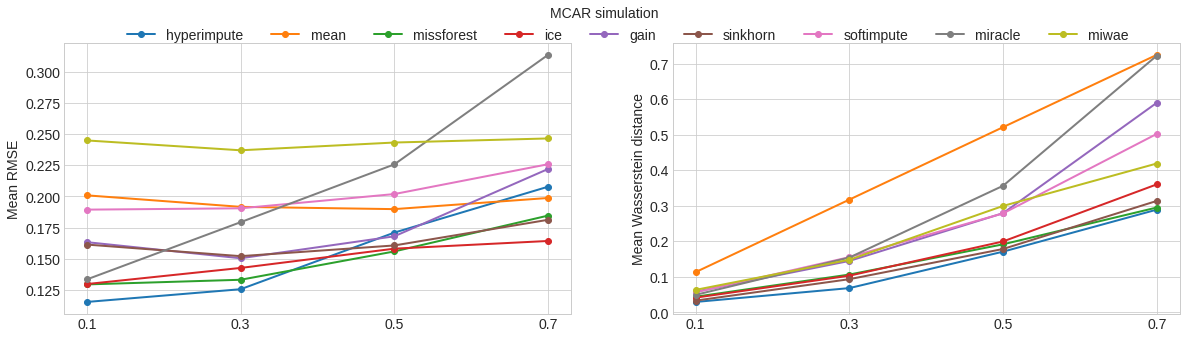

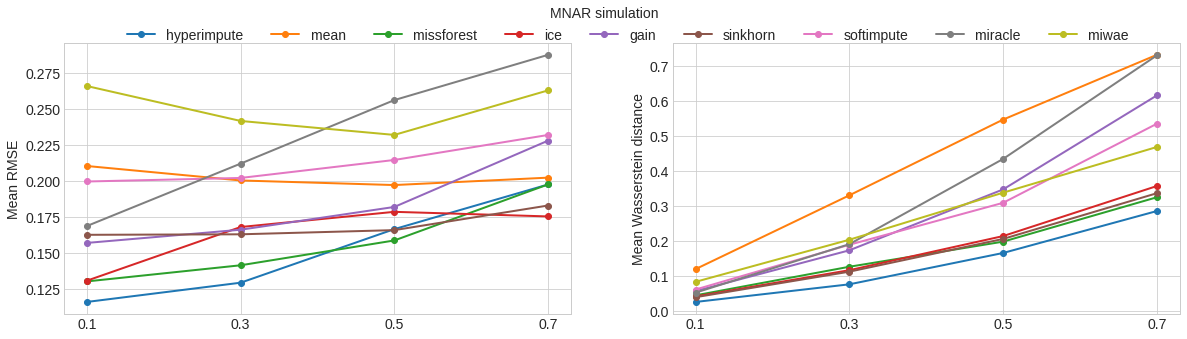

In [7]:
import numpy as np

x_axis = [0.1, 0.3, 0.5, 0.7]

fontsize = 14

def generate_plot_for_ax(ax, scenario, metric):
    offset = len(data)

    barWidth = 1

    max_val = 0
    idx = 0

    for model in results[scenario][0.1][metric]:

        datapoints = []

        for miss in results[scenario]:
            local_res = np.asarray(results[scenario][miss][metric][model])
            datapoints.append(np.mean(local_res))

        ax.plot(
            x_axis,
            datapoints,
            label=str(model),
            linewidth=2,
            marker="o",
        )

    ax.set_xticks(x_axis, fontsize=fontsize)
    ax.set_ylabel(metric, fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot(scenario):
    plt.style.use("seaborn-whitegrid")

    offset = len(data)

    metrics = list(results[scenario][0.1].keys())
    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5
                                                     ))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax(axs[idx], scenario, metric)

    # plt.title(f"{scenario} simulation with {miss} missingness", fontdict = {"fontsize": 150}, loc = "top")

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.1, 1.1),
        ncol=models_cnt,
        prop={"size": fontsize},
    )
    fig.suptitle(f"{scenario} simulation", fontsize=fontsize)
    plt.savefig(output_dir / f"error_by_miss_{scenario}.png")

    plt.show()


for scenario in ["MAR", "MCAR", "MNAR"]:
    generate_plot(scenario)

#### By dataset size

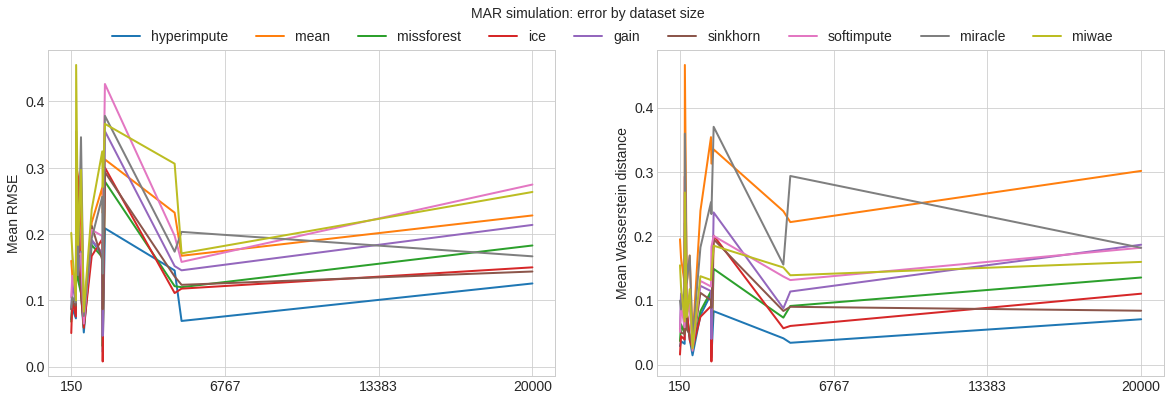

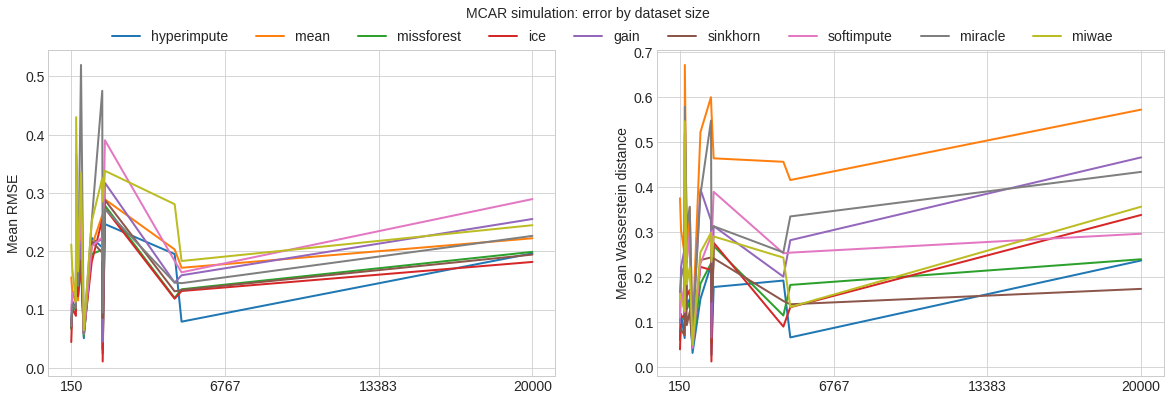

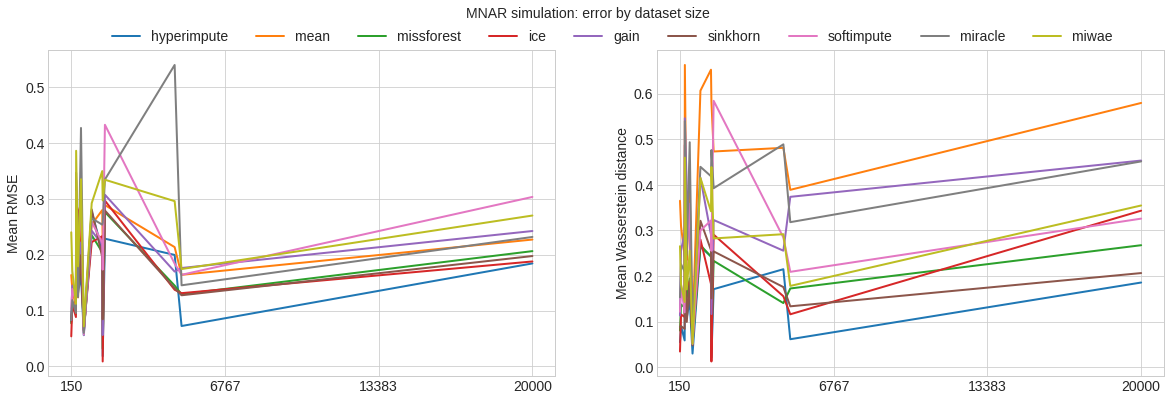

In [16]:
import numpy as np

x_axis = [len(raw_datasets[dataset]) for dataset in data]
x_axis = np.asarray(x_axis)

sorted_args = np.argsort(x_axis)
norm_x_axis = np.linspace(min(x_axis), max(x_axis), 4)
fontsize = 14


def generate_plot_for_ax(ax, scenario, metric):
    offset = len(data)

    barWidth = 1

    max_val = 0
    idx = 0

    ## We selected the same dataset from every model, and average across missingness pct
    for model in results[scenario][0.1][metric]:
        datapoints = []

        for df_idx in range(len(results[scenario][0.1][metric][model])):
            local_datapoints = []

            for miss in results[scenario]:
                local_datapoints.append(
                    np.mean(results[scenario][miss][metric][model][df_idx])
                )

            datapoints.append(np.mean(local_datapoints))
            #datapoints.append(results[scenario][0.3][metric][model][df_idx])

  
        ax.plot(
            np.asarray(x_axis)[sorted_args],
            np.asarray(datapoints)[sorted_args],
            label=str(model),
            linewidth=2,
        )

    ax.set_xticks(norm_x_axis, fontsize=fontsize)
    ax.set_ylabel(metric, fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot(scenario):
    plt.style.use("seaborn-whitegrid")

    offset = len(data)

    metrics = list(results[scenario][0.1].keys())
    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 6))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax(axs[idx], scenario, metric)

    # plt.title(f"{scenario} simulation with {miss} missingness", fontdict = {"fontsize": 150}, loc = "top")

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.1, 1.1),
        ncol=models_cnt,
        prop={"size": fontsize},
    )
    fig.suptitle(f"{scenario} simulation: error by dataset size", fontsize=fontsize)
    plt.savefig(output_dir / f"error_by_df_size_{scenario}.png")

    plt.show()


# generate_plot("MAR")
for scenario in ["MAR", "MCAR", "MNAR"]:
    generate_plot(scenario)

In [9]:
from IPython.display import HTML, display
import tabulate

dbg_headers = ["Dataset", "Length", "Features"]

dbg_results = []

for dataset in raw_datasets:
    dbg_results.append([dataset, raw_datasets[dataset].shape[0], raw_datasets[dataset].shape[1]])
   
display(HTML(tabulate.tabulate(dbg_results, headers=dbg_headers, tablefmt="html")))


Dataset,Length,Features
airfoil,1503,6
blood,748,5
bc,569,30
california,20640,8
climate,540,21
compression,1030,9
slump,103,11
sonar,208,61
diabetes,442,10
wine_red,1599,12
